In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from sklearn import calibration

In [3]:
def get_predictions(f_test, pred_path, prob_pred_path, clf_path=None, predict=False):
    if predict:
        # load classifier
        clf = load(clf_path)

        # make deterministic and probabilistic predictions
        l_pred = clf.predict(f_test)
        l_prob_pred = clf.predict_proba(f_test)

        # save predictions
        np.save(pred_path, l_pred)
        np.save(prob_pred_path, l_prob_pred)
    else:
        # load predictions
        l_pred = np.load(f"{pred_path}.npy")
        l_prob_pred = np.load(f"{prob_pred_path}.npy")
    
    return l_pred, l_prob_pred

def get_results(f_test, l_test, l_rf_pred, l_rf_prob_pred):
    # create DataFrame of results
    results = f_test.copy()
    results['tag pred'] = l_rf_pred
    results['tag actual'] = l_test
    results['0 prob'] = l_rf_prob_pred[:,0]
    results['1 prob'] = l_rf_prob_pred[:,1]
    return results

def statistical_metrics(results, l_prob_pred, omit_auc=False):
    """
    Prints statistical metrics (for both orbiting and infalling): 
    accuracy, recall, precision, Brier score, ROC AUC score
    
    Args:
        results: results DataFrame
        df_prob: probabilistic predictions DataFrame
        l_test: test set of labels (tags)
        l_prob_pred: probabilistic predictions
    """
    # ROC AUC score
    if not omit_auc:
        auc_scores = metrics.roc_auc_score(results['tag actual'], l_prob_pred, multi_class="ovr", average=None)
        orbiting_auc = auc_scores[0]
        infalling_auc = auc_scores[1]
    
    # orbiting
    orbiting_TPs = np.sum((results['tag actual']==0.0) & (results['tag pred']==0.0))
    orbiting_FPs = np.sum((results['tag actual']!=0.0) & (results['tag pred']==0.0))
    orbiting_TNs = np.sum((results['tag actual']!=0.0) & (results['tag pred']!=0.0))
    orbiting_FNs = np.sum((results['tag actual']==0.0) & (results['tag pred']!=0.0))
    orbiting_accuracy = (orbiting_TPs+orbiting_TNs)/len(results)
    orbiting_precision = (orbiting_TPs)/(orbiting_TPs+orbiting_FPs)
    orbiting_recall = (orbiting_TPs)/(orbiting_TPs+orbiting_FNs)
    orbiting_brier = metrics.brier_score_loss(results['tag actual']==0.0, results['0 prob'], pos_label=1.0)
    print("Orbiting Accuracy: ", orbiting_accuracy)
    print("Orbiting Precision: ", orbiting_precision)
    print("Orbiting Recall: ", orbiting_recall)
    if not omit_auc:
        print("Orbiting ROC AUC: ", orbiting_auc)
    print("Orbiting Brier: ", orbiting_brier)
    print()
    
    #infalling
    infalling_TPs = np.sum((results['tag actual']==1.0) & (results['tag pred']==1.0))
    infalling_FPs = np.sum((results['tag actual']!=1.0) & (results['tag pred']==1.0))
    infalling_TNs = np.sum((results['tag actual']!=1.0) & (results['tag pred']!=1.0))
    infalling_FNs = np.sum((results['tag actual']==1.0) & (results['tag pred']!=1.0))
    infalling_accuracy = (infalling_TPs+infalling_TNs)/len(results)
    infalling_precision = (infalling_TPs)/(infalling_TPs+infalling_FPs)
    infalling_recall = (infalling_TPs)/(infalling_TPs+infalling_FNs)
    infalling_brier = metrics.brier_score_loss(results['tag actual']==1.0, results['1 prob'], pos_label=1.0)
    print("Infalling Accuracy: ", infalling_accuracy)
    print("Infalling Precision: ", infalling_precision)
    print("Infalling Recall: ", infalling_recall)
    if not omit_auc:
        print("Infalling ROC AUC: ", infalling_auc)
    print("Infalling Brier: ", infalling_brier)

def find_bin(pts,bin,binsize='None'):
    '''
    Return the index of bin pt belongs to bin, where the returned index corresponds to binmid.
    If it is equal to bin edge, it will put in lower bin.
    If the bin is equally spaced linearly, binsize='linear' and logarithmically, binsize='log'
    for faster execution.
    '''
    if binsize=='linear':
        size = bin[1]-bin[0]
        pts = pts-bin[0]
        return np.floor(pts/size).astype('int')
    elif binsize=='log':
        size = np.log(bin[1]/bin[0])
        pts = np.log(pts/bin[0])
        return np.floor(pts/size).astype('int')
    else:
        if hasattr(pts, "__len__"):
            ptscopy = np.array([pts]*len(bin))
            bincopy = np.array([bin]*len(pts))
            return np.sum(ptscopy.T>bincopy,axis=1)-1        
        else:
            return np.sum(pts>bin)-1

In [4]:
data2d = pd.read_pickle("/home/djf47/nagai/2d_data")
l = data2d['tag']

# MDPL2 Model Applied to MDPL2 Data

## Random Forest (RF)

**Input Features:** d2d, v, mratio, ssfr


**In text:** Table 3

In [4]:
# split into features and labels
f = data2d[['d2d', 'v', 'mratio', 'ssfr']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_rf_pred, l_rf_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/all_features_rf_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/all_features_rf_prob_pred"
)

results = get_results(f_test, l_test, l_rf_pred, l_rf_prob_pred)

In [5]:
statistical_metrics(results, l_rf_prob_pred)

Orbiting Accuracy:  0.958261262575479
Orbiting Precision:  0.7120247478732297
Orbiting Recall:  0.7699917211549834
Orbiting ROC AUC:  0.97538592748609
Orbiting Brier:  0.028873713081103057

Infalling Accuracy:  0.7901764083754904
Infalling Precision:  0.5536881448364724
Infalling Recall:  0.4976683015196
Infalling ROC AUC:  0.8379184386275546
Infalling Brier:  0.13327481348435188


## k-Nearest-Neighbors (kNN)

**Input Features:** d2d, v, mratio, ssfr

**In text:** Table 3

In [6]:
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_knn_pred, l_knn_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/all_features_knn_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/all_features_knn_prob_pred"
)

results = get_results(f_test, l_test, l_knn_pred, l_knn_prob_pred)

In [7]:
statistical_metrics(results, l_knn_prob_pred)

Orbiting Accuracy:  0.9538842665193992
Orbiting Precision:  0.6751023473625306
Orbiting Recall:  0.774553533715174
Orbiting ROC AUC:  0.9624043166469938
Orbiting Brier:  0.0314869412996702

Infalling Accuracy:  0.7874965484185245
Infalling Precision:  0.5486785372342134
Infalling Recall:  0.47888572013448977
Infalling ROC AUC:  0.826847389162139
Infalling Brier:  0.13661019676764097


## Logistic Regression

**Input Features:** d2d, v, mratio, ssfr

**In text:** Table 3

In [15]:
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_logi_pred, l_logi_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/all_features_logi_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/all_features_logi_prob_pred"
)

results = get_results(f_test, l_test, l_logi_pred, l_logi_prob_pred)

In [16]:
statistical_metrics(results, l_logi_prob_pred)

Orbiting Accuracy:  0.9486893107777911
Orbiting Precision:  0.6364256715306833
Orbiting Recall:  0.7800023653842905
Orbiting ROC AUC:  0.9717427025582458
Orbiting Brier:  0.03368539845407257

Infalling Accuracy:  0.7596084213378069
Infalling Precision:  0.38442224970923256
Infalling Recall:  0.05839201137386535
Infalling ROC AUC:  0.6599907286855956
Infalling Brier:  0.16880501112668153


## RF (without sSFR)

**Input Features:** d2d, v, mratio

**In text:** Table 2

In [8]:
f = data2d[['d2d', 'v', 'mratio']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_rf_pred, l_rf_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_mratio_rf_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_mratio_rf_prob_pred"
)

results = get_results(f_test, l_test, l_rf_pred, l_rf_prob_pred)

In [9]:
statistical_metrics(results, l_rf_prob_pred)

Orbiting Accuracy:  0.9541265284644761
Orbiting Precision:  0.6873797945366128
Orbiting Recall:  0.742730667207326
Orbiting ROC AUC:  0.9701813528253211
Orbiting Brier:  0.031511511477694105

Infalling Accuracy:  0.7849996874039419
Infalling Precision:  0.5447990575746087
Infalling Recall:  0.45130353582515204
Infalling ROC AUC:  0.8297441374466222
Infalling Brier:  0.13589568052669046


## RF (without sSFR or mratio)

**Input Features:** d2d, v

**In text:** Table 1

In [15]:
f = data2d[['d2d', 'v']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_rf_pred, l_rf_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_rf_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_rf_prob_pred"
)

results = get_results(f_test, l_test, l_rf_pred, l_rf_prob_pred)

In [11]:
statistical_metrics(results, l_rf_prob_pred)

Orbiting Accuracy:  0.9472442052505717
Orbiting Precision:  0.6460316715909269
Orbiting Recall:  0.6982276513423555
Orbiting ROC AUC:  0.9611229694771832
Orbiting Brier:  0.03614219923049269

Infalling Accuracy:  0.7729230596902174
Infalling Precision:  0.5123831848726363
Infalling Recall:  0.45971335391621587
Infalling ROC AUC:  0.8108181568319052
Infalling Brier:  0.14740794409911206


## KNN (without sSFR)

**Input Features:** d2d, v, mratio

**In text:** Table 2

In [12]:
f = data2d[['d2d', 'v', 'mratio']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_knn_pred, l_knn_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_mratio_knn_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_mratio_knn_prob_pred"
)

results = get_results(f_test, l_test, l_knn_pred, l_knn_prob_pred)

In [13]:
statistical_metrics(results, l_knn_prob_pred)

Orbiting Accuracy:  0.9524105063535149
Orbiting Precision:  0.6631608520570247
Orbiting Recall:  0.7776876679000456
Orbiting ROC AUC:  0.9609656044576969
Orbiting Brier:  0.03245834802245365

Infalling Accuracy:  0.787797422124507
Infalling Precision:  0.5500576010622026
Infalling Recall:  0.4739811613344662
Infalling ROC AUC:  0.8250265808267109
Infalling Brier:  0.13712549110866828


## kNN (without sSFR or mratio)

**Input Features:** d2d, v

**Input text:** Table 1

In [40]:
f = data2d[['d2d', 'v']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_knn_pred, l_knn_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_knn_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_knn_prob_pred"
)

results = get_results(f_test, l_test, l_knn_pred, l_knn_prob_pred)

In [15]:
statistical_metrics(results, l_knn_prob_pred)

Orbiting Accuracy:  0.9500797119948318
Orbiting Precision:  0.6526482942321483
Orbiting Recall:  0.753434031121699
Orbiting ROC AUC:  0.9587029521600736
Orbiting Brier:  0.03388632444344877

Infalling Accuracy:  0.7850876050453004
Infalling Precision:  0.5428935360603666
Infalling Recall:  0.4720995381470358
Infalling ROC AUC:  0.8226604912422336
Infalling Brier:  0.1380048006650191


## Logistic Regression (without sSFR)

**Input Features**: d2d, v, mratio

**In text:** Table 2

In [20]:
f = data2d[['d2d', 'v', 'mratio']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_logi_pred, l_logi_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_mratio_logi_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_mratio_logi_prob_pred"
)

results = get_results(f_test, l_test, l_logi_pred, l_logi_prob_pred)

In [21]:
statistical_metrics(results, l_logi_prob_pred)

Orbiting Accuracy:  0.9436936350232623
Orbiting Precision:  0.6057231070945857
Orbiting Recall:  0.772323314241303
Orbiting ROC AUC:  0.9682148535281802
Orbiting Brier:  0.03607648517904529

Infalling Accuracy:  0.7607148811353489
Infalling Precision:  0.37169211799298113
Infalling Recall:  0.04395595150964507
Infalling ROC AUC:  0.6543850108918503
Infalling Brier:  0.16966023874412436


## Logistic Regression (without sSFR or mratio)

**Input Features:** d2d, v

**In text:** Table 1

In [24]:
f = data2d[['d2d', 'v', 'mratio']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_logi_pred, l_logi_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_logi_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_logi_prob_pred"
)

results = get_results(f_test, l_test, l_logi_pred, l_logi_prob_pred)

In [25]:
statistical_metrics(results, l_logi_prob_pred)

Orbiting Accuracy:  0.9426724878999276
Orbiting Precision:  0.6004475220781972
Orbiting Recall:  0.7662155540912701
Orbiting ROC AUC:  0.9675051798222294
Orbiting Brier:  0.036574546001652816

Infalling Accuracy:  0.7595315748068416
Infalling Precision:  0.3502736512900704
Infalling Recall:  0.041457402686991565
Infalling ROC AUC:  0.6526090312179827
Infalling Brier:  0.16993231424371383


# MDPL2 Model Applied to TNG Data

In [77]:
data_TNG = pd.read_pickle("/home/djf47/nagai/data_TNG")
l = data_TNG['orbiting']

## Random Forest (RF)

**Input Features:** d2d, v, mratio, ssfr

**In text:** Table 6

In [63]:
f = data_TNG[['d2d', 'v', 'mratio', 'ssfr']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_rf_pred, l_rf_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_all_features_rf_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_all_features_rf_prob_pred"
)

results = get_results(f_test, l_test, l_rf_pred, l_rf_prob_pred)

In [64]:
statistical_metrics(results, l_rf_prob_pred, omit_auc=True)

Orbiting Accuracy:  0.8149046308818729
Orbiting Precision:  0.6771796266086642
Orbiting Recall:  0.6306549628629304
Orbiting Brier:  0.11251511448957703

Infalling Accuracy:  0.5366320011192464
Infalling Precision:  0.7823975720789075
Infalling Recall:  0.4983568528900058
Infalling Brier:  0.2993065569183416


## k-Nearest-Neighbors (kNN)

**Input Features:** d2d, v, mratio, ssfr

**In text:** Table 6

In [20]:
f = data_TNG[['d2d', 'v', 'mratio', 'ssfr']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_knn_pred, l_knn_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_all_features_knn_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_all_features_knn_prob_pred"
)

results = get_results(f_test, l_test, l_knn_pred, l_knn_prob_pred)

In [21]:
statistical_metrics(results, l_knn_prob_pred, omit_auc=True)

Orbiting Accuracy:  0.9095275847595952
Orbiting Precision:  0.7749861954721149
Orbiting Recall:  0.9476704929101958
Orbiting Brier:  0.06468290610248359

Infalling Accuracy:  0.6205288439117661
Infalling Precision:  0.9649785840262031
Infalling Recall:  0.4935885044139442
Infalling Brier:  0.26544109188701837


## Logistic Regression

**Input Features:** d2d, v, mratio, ssfr

**In text:** Table 6

In [132]:
f = data_TNG[['d2d', 'v', 'mratio', 'ssfr']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_logi_pred, l_logi_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_all_features_logi_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_all_features_logi_prob_pred"
)

results = get_results(f_test, l_test, l_logi_pred, l_logi_prob_pred)

## RF (without sSFR)

**Input Features:** d2d, v, mratio

**In text:** Table 5

In [22]:
f = data_TNG[['d2d', 'v', 'mratio']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_rf_pred, l_rf_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_mratio_rf_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_mratio_rf_prob_pred"
)

results = get_results(f_test, l_test, l_rf_pred, l_rf_prob_pred)

In [39]:
statistical_metrics(results, l_rf_prob_pred, omit_auc=True)

Orbiting Accuracy:  0.8717996548990347
Orbiting Precision:  0.7167827393144885
Orbiting Recall:  0.8860567184334909
Orbiting Brier:  0.08390740494077256

Infalling Accuracy:  0.559390010726111
Infalling Precision:  0.9182857930274217
Infalling Recall:  0.42940911141181776
Infalling Brier:  0.2910586459918048


## RF (without sSFR or mratio)

**Input Features:** d2d, v

**In text:** Table 4

In [24]:
f = data_TNG[['d2d', 'v']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_rf_pred, l_rf_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_rf_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_rf_prob_pred"
)

results = get_results(f_test, l_test, l_rf_pred, l_rf_prob_pred)

In [41]:
statistical_metrics(results, l_rf_prob_pred, omit_auc=True)

Orbiting Accuracy:  0.876882898848109
Orbiting Precision:  0.7581761006289308
Orbiting Recall:  0.8139770425388251
Orbiting Brier:  0.08459552301450357

Infalling Accuracy:  0.5796297159912326
Infalling Precision:  0.8900347763520806
Infalling Recall:  0.478252464720665
Infalling Brier:  0.29042135428811267


## KNN (without sSFR)

**Input Features:** d2d, v, mratio

**In text:** Table 5

In [26]:
f = data_TNG[['d2d', 'v', 'mratio']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_knn_pred, l_knn_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_mratio_knn_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_mratio_knn_prob_pred"
)

results = get_results(f_test, l_test, l_knn_pred, l_knn_prob_pred)

In [27]:
statistical_metrics(results, l_knn_prob_pred, omit_auc=True)

Orbiting Accuracy:  0.8845310824045143
Orbiting Precision:  0.7351978171896316
Orbiting Recall:  0.9096893990546928
Orbiting Brier:  0.07716167410240068

Infalling Accuracy:  0.5938068367299352
Infalling Precision:  0.9395739186571982
Infalling Recall:  0.468909079193247
Infalling Brier:  0.2786401156554587


## KNN (without sSFR or mratio)

**Input Features:** d2d, v

**In text:** Table 4

In [40]:
f = data_TNG[['d2d', 'v']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_knn_pred, l_knn_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_knn_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_knn_prob_pred"
)

results = get_results(f_test, l_test, l_knn_pred, l_knn_prob_pred)

In [29]:
statistical_metrics(results, l_knn_prob_pred, omit_auc=True)

Orbiting Accuracy:  0.8877489157300751
Orbiting Precision:  0.7570530624177751
Orbiting Recall:  0.8742403781228899
Orbiting Brier:  0.07832983568841426

Infalling Accuracy:  0.598423728023131
Infalling Precision:  0.9191747572815534
Infalling Recall:  0.48804691023906177
Infalling Brier:  0.27649696611688873


## Logistic Regression (without sSFR)

**Input Features:** d2d, v, mratio

**In text:** Table 5

In [160]:
f = data_TNG[['d2d', 'v', 'mratio']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_logi_pred, l_logi_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_mratio_logi_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_mratio_logi_prob_pred"
)

results = get_results(f_test, l_test, l_logi_pred, l_logi_prob_pred)

## Logistic Regression (without sSFR or mratio)

**Input Features:** d2d, v

**In text:** Table 4

In [167]:
f = data_TNG[['d2d', 'v']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_logi_pred, l_logi_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_logi_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/tng_d2d_v_logi_prob_pred"
)

results = get_results(f_test, l_test, l_logi_pred, l_logi_prob_pred)

# ROC Curves

The code cells below generate ROC curves (Fig. 2 in text) using the classifier trained and tested on MDPL2 with d2d and v as input features.

In [176]:
l = data2d['tag']

In [177]:
f = data2d[['d2d', 'v']]
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_rf_pred, l_rf_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_rf_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_rf_prob_pred"
)

In [178]:
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_knn_pred, l_knn_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_knn_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_knn_prob_pred"
)

In [179]:
f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_logi_pred, l_logi_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_logi_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_logi_prob_pred"
)

## Orbiting

In [180]:
l_rf_prob_pred_orbiting = np.empty([len(l_rf_prob_pred), 2])
for index, prob_vec in enumerate(l_rf_prob_pred):
    l_rf_prob_pred_orbiting[index] = [prob_vec[0], prob_vec[1] + prob_vec[2]]
    
l_knn_prob_pred_orbiting = np.empty([len(l_knn_prob_pred), 2])
for index, prob_vec in enumerate(l_knn_prob_pred):
    l_knn_prob_pred_orbiting[index] = [prob_vec[0], prob_vec[1] + prob_vec[2]]
    
l_logi_prob_pred_orbiting = np.empty([len(l_logi_prob_pred), 2])
for index, prob_vec in enumerate(l_logi_prob_pred):
    l_logi_prob_pred_orbiting[index] = [prob_vec[0], prob_vec[1] + prob_vec[2]]

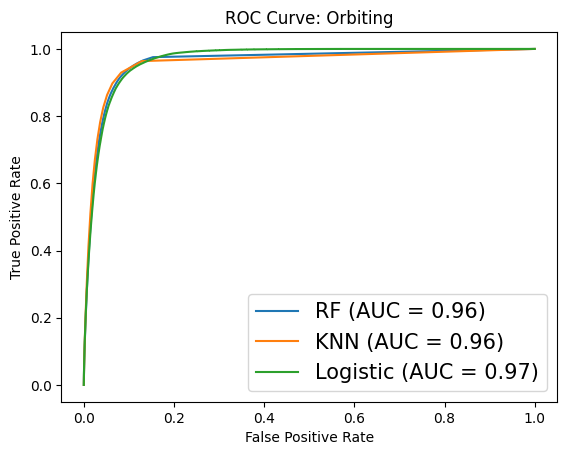

In [181]:
fpr_rf_orbit, tpr_rf_orbit, thresh_rf = metrics.roc_curve(l_test, l_rf_prob_pred_orbiting[:, 0], pos_label=0)
fpr_knn_orbit, tpr_knn_orbit, thresh_knn = metrics.roc_curve(l_test, l_knn_prob_pred_orbiting[:, 0], pos_label=0)
fpr_logi_orbit, tpr_logi_orbit, thresh_logi = metrics.roc_curve(l_test, l_logi_prob_pred_orbiting[:, 0], pos_label=0)

plt.plot(fpr_rf_orbit, tpr_rf_orbit, label=f"RF (AUC = 0.96)")
plt.plot(fpr_knn_orbit, tpr_knn_orbit, label=f"KNN (AUC = 0.96)")
plt.plot(fpr_logi_orbit, tpr_logi_orbit, label=f"Logistic (AUC = 0.97)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Orbiting")
plt.legend(loc="best", prop={'size': 15})

## Infalling

In [182]:
l_rf_prob_pred_infalling = np.empty([len(l_rf_prob_pred), 2])
for index, prob_vec in enumerate(l_rf_prob_pred):
    l_rf_prob_pred_infalling[index] = [prob_vec[0] + prob_vec[2], prob_vec[1]]

l_knn_prob_pred_infalling = np.empty([len(l_knn_prob_pred), 2])
for index, prob_vec in enumerate(l_knn_prob_pred):
    l_knn_prob_pred_infalling[index] = [prob_vec[0] + prob_vec[2], prob_vec[1]]

l_logi_prob_pred_infalling = np.empty([len(l_logi_prob_pred), 2])
for index, prob_vec in enumerate(l_logi_prob_pred):
    l_logi_prob_pred_infalling[index] = [prob_vec[0] + prob_vec[2], prob_vec[1]]

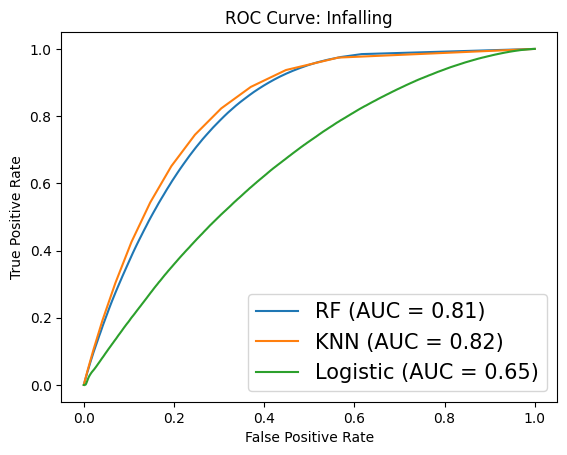

In [183]:
fpr_rf_infall, tpr_rf_infall, thresh_rf = metrics.roc_curve(l_test, l_rf_prob_pred_infalling[:, 1], pos_label=1)
fpr_knn_infall, tpr_knn_infall, thresh_knn = metrics.roc_curve(l_test, l_knn_prob_pred_infalling[:, 1], pos_label=1)
fpr_logi_infall, tpr_logi_infall, thresh_logi = metrics.roc_curve(l_test, l_logi_prob_pred_infalling[:, 1], pos_label=1)

plt.plot(fpr_rf_infall, tpr_rf_infall, label=f"RF (AUC = 0.81)")
plt.plot(fpr_knn_infall, tpr_knn_infall, label=f"KNN (AUC = 0.82)")
plt.plot(fpr_logi_infall, tpr_logi_infall, label=f"Logistic (AUC = 0.65)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Infalling")
plt.legend(loc="best", prop={'size': 15})

## Combined

In [184]:
# for unity line
unity_line_xs = [0, 0.2, 0.4, 0.6, 0.8, 1]
unity_line_ys = unity_line_xs

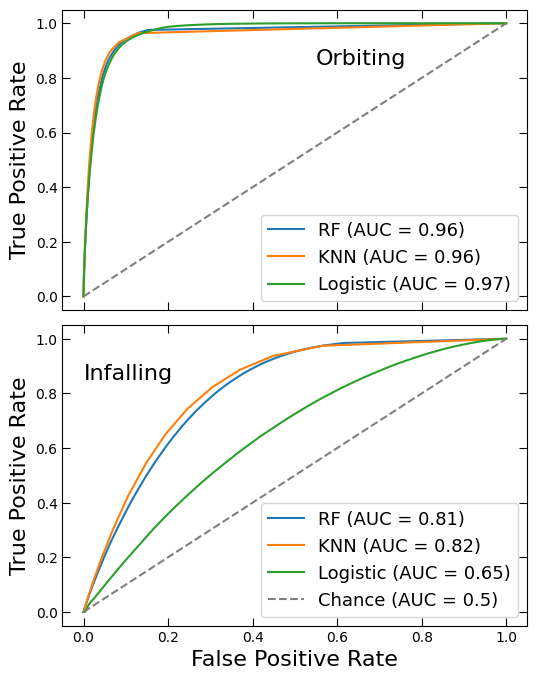

In [212]:
fig = plt.figure(figsize=(6,8))
gs = gridspec.GridSpec(2,1, height_ratios = [1,1], hspace = 0.05)

ax0 = plt.subplot(gs[0])
ax0.plot(fpr_rf_orbit, tpr_rf_orbit, label=f"RF (AUC = 0.96)")
ax0.plot(fpr_knn_orbit, tpr_knn_orbit, label=f"KNN (AUC = 0.96)")
ax0.plot(fpr_logi_orbit, tpr_logi_orbit, label=f"Logistic (AUC = 0.97)")
ax0.plot(unity_line_xs, unity_line_ys, color="grey", linestyle="--")
ax0.set_ylabel("True Positive Rate", fontsize=16)
ax0.text(0.55, 0.85, "Orbiting", fontsize=16)
ax0.legend(fontsize=13)
ax0.xaxis.set_ticklabels([])

ax1 = plt.subplot(gs[1])
ax1.plot(fpr_rf_infall, tpr_rf_infall, label=f"RF (AUC = 0.81)")
ax1.plot(fpr_knn_infall, tpr_knn_infall, label=f"KNN (AUC = 0.82)")
ax1.plot(fpr_logi_infall, tpr_logi_infall, label=f"Logistic (AUC = 0.65)")
ax1.plot(unity_line_xs, unity_line_ys, color="grey", linestyle="--", label="Chance (AUC = 0.5)")
ax1.set_ylabel("True Positive Rate", fontsize=16)
ax1.set_xlabel("False Positive Rate", fontsize=16)
ax1.text(0, 0.85, "Infalling", fontsize=16)
ax1.legend(fontsize=13)

ax0.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax1.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)

# Calibration Plots

The code cells below generate calibration curves (Fig. 2 in text) using the classifier trained and tested on MDPL2 with d2d and v as input features.

In [195]:
# for unity line
unity_line_xs = [0, 0.2, 0.4, 0.6, 0.8, 1]
unity_line_ys = unity_line_xs

In [197]:
f = data2d[['d2d', 'v']]
l = data2d['tag']

f_train, f_test, l_train, l_test = train_test_split(f, l, test_size = 0.3, random_state=8)

l_knn_pred, l_knn_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_knn_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_knn_prob_pred"
)

l_rf_pred, l_rf_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_rf_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_rf_prob_pred"
)

l_logi_pred, l_logi_prob_pred = get_predictions(
    f_test, 
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_logi_pred",
    "/home/djf47/nagai/C2_GaMe_notebooks/saved_predictions/d2d_v_logi_prob_pred"
)

In [198]:
l_rf_prob_pred_orbiting = np.empty([len(l_rf_prob_pred), 2])
for index, prob_vec in enumerate(l_rf_prob_pred):
    l_rf_prob_pred_orbiting[index] = [prob_vec[0], prob_vec[1] + prob_vec[2]]
    
l_knn_prob_pred_orbiting = np.empty([len(l_knn_prob_pred), 2])
for index, prob_vec in enumerate(l_knn_prob_pred):
    l_knn_prob_pred_orbiting[index] = [prob_vec[0], prob_vec[1] + prob_vec[2]]

l_logi_prob_pred_orbiting = np.empty([len(l_logi_prob_pred), 2])
for index, prob_vec in enumerate(l_logi_prob_pred):
    l_logi_prob_pred_orbiting[index] = [prob_vec[0], prob_vec[1] + prob_vec[2]]

In [199]:
# orbiting vs non-orbiting
l_rf_test_orbiting = np.array(l_test)
l_rf_test_orbiting[l_test == 2] = 1

l_knn_test_orbiting = np.array(l_test)
l_knn_test_orbiting[l_test == 2] = 1

l_logi_test_orbiting = np.array(l_test)
l_logi_test_orbiting[l_test == 2] = 1

# infalling vs non-infalling
l_rf_test_infalling = np.array(l_test)
l_rf_test_infalling[l_test == 2] = 0

l_knn_test_infalling = np.array(l_test)
l_knn_test_infalling[l_test == 2] = 0

l_logi_test_infalling = np.array(l_test)
l_logi_test_infalling[l_test == 2] = 0

## Orbiting

Model trained on MDPL2, tested on MDPL2, with 2d radius and LOS velocity as input features

In [200]:
cal_curve_orbiting_rf = calibration.calibration_curve(l_rf_test_orbiting, l_rf_prob_pred_orbiting[:, 0], pos_label=0, n_bins=10)
cal_curve_orbiting_knn = calibration.calibration_curve(l_knn_test_orbiting, l_knn_prob_pred_orbiting[:, 0], pos_label=0, n_bins=10)
cal_curve_orbiting_logi = calibration.calibration_curve(l_logi_test_orbiting, l_logi_prob_pred_orbiting[:, 0], pos_label=0, n_bins=10)

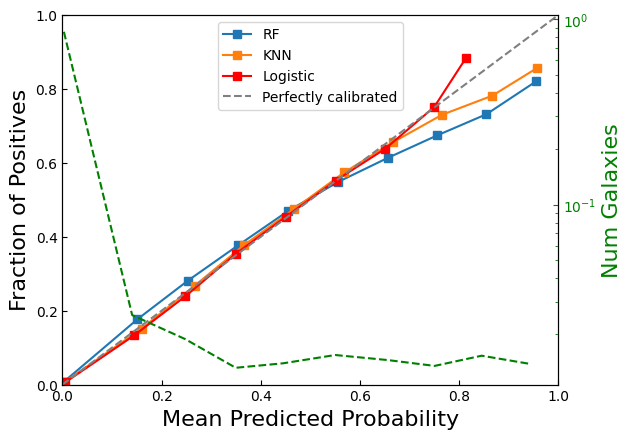

In [203]:
n_bins = 10
bin_edge = np.linspace(0,1,num=11)
bins = find_bin(results['0 prob'],bin_edge,binsize='linear')
orbiting_prob_true = np.zeros(len(bin_edge)-1)
orbiting_prob_pred = np.zeros(len(bin_edge)-1)
orbiting_num_gals = np.zeros(len(bin_edge)-1)

for i in range(len(bin_edge)-1):
    mask = bins==i
    orbiting_num_gals[i] = np.sum(mask)
    orbiting_prob_true[i] = np.sum(results['tag actual'][mask]==0.0)/orbiting_num_gals[i]
    orbiting_prob_pred[i] = np.mean(results['0 prob'][mask])
orbiting_num_gals = orbiting_num_gals/np.sum(orbiting_num_gals)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(cal_curve_orbiting_rf[1], cal_curve_orbiting_rf[0], marker="s", label="RF")
ax1.plot(cal_curve_orbiting_knn[1], cal_curve_orbiting_knn[0], marker="s", label="KNN")
ax1.plot(cal_curve_orbiting_logi[1], cal_curve_orbiting_logi[0], marker="s", label="Logistic", color="red")
ax1.plot(unity_line_xs, unity_line_ys, color="grey", linestyle="--", label="Perfectly calibrated")
ax1.legend(loc='upper center')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax2.plot(orbiting_prob_pred, orbiting_num_gals,c='g',ls='--')
ax2.set_yscale('log')
ax2.set_ylabel('Num Galaxies', fontsize=16,c='g')
ax1.set_ylabel("Fraction of Positives", fontsize=16)
ax1.set_xlabel("Mean Predicted Probability", fontsize=16)
ax1.tick_params(direction='in')
ax2.tick_params(direction='in',color='g',which='both',labelcolor='g')

## Infalling

In [204]:
l_rf_prob_pred_infalling = np.empty([len(l_rf_prob_pred), 2])
for index, prob_vec in enumerate(l_rf_prob_pred):
    l_rf_prob_pred_infalling[index] = [prob_vec[0] + prob_vec[2], prob_vec[1]]

l_knn_prob_pred_infalling = np.empty([len(l_knn_prob_pred), 2])
for index, prob_vec in enumerate(l_knn_prob_pred):
    l_knn_prob_pred_infalling[index] = [prob_vec[0] + prob_vec[2], prob_vec[1]]

l_logi_prob_pred_infalling = np.empty([len(l_logi_prob_pred), 2])
for index, prob_vec in enumerate(l_logi_prob_pred):
    l_logi_prob_pred_infalling[index] = [prob_vec[0] + prob_vec[2], prob_vec[1]]

In [205]:
cal_curve_infalling_rf = calibration.calibration_curve(l_rf_test_infalling, l_rf_prob_pred_infalling[:, 1], pos_label=1, n_bins=10)
cal_curve_infalling_knn = calibration.calibration_curve(l_knn_test_infalling, l_knn_prob_pred_infalling[:, 1], pos_label=1, n_bins=10)
cal_curve_infalling_logi = calibration.calibration_curve(l_logi_test_infalling, l_logi_prob_pred_infalling[:, 1], pos_label=1, n_bins=10)

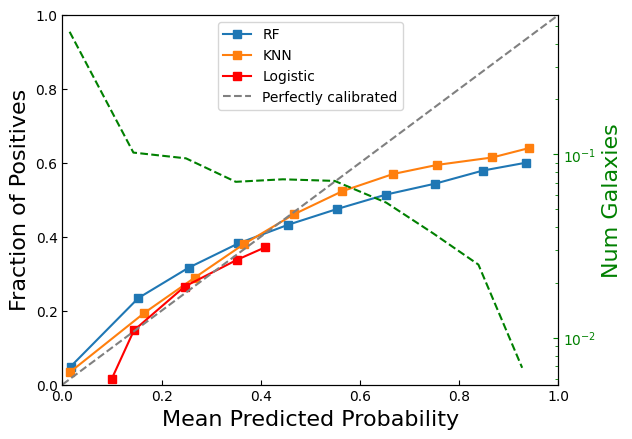

In [210]:
n_bins = 10
bin_edge = np.linspace(0,1,num=11)
bins = find_bin(results['1 prob'],bin_edge,binsize='linear')
infalling_prob_true = np.zeros(len(bin_edge)-1)
infalling_prob_pred = np.zeros(len(bin_edge)-1)
infalling_num_gals = np.zeros(len(bin_edge)-1)

for i in range(len(bin_edge)-1):
    mask = bins==i
    infalling_num_gals[i] = np.sum(mask)
    infalling_prob_true[i] = np.sum(results['tag actual'][mask]==1.0)/infalling_num_gals[i]
    infalling_prob_pred[i] = np.mean(results['1 prob'][mask])
infalling_num_gals = infalling_num_gals/np.sum(infalling_num_gals)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(cal_curve_infalling_rf[1], cal_curve_infalling_rf[0], marker="s", label="RF")
ax1.plot(cal_curve_infalling_knn[1], cal_curve_infalling_knn[0], marker="s", label="KNN")
ax1.plot(cal_curve_infalling_logi[1], cal_curve_infalling_logi[0], marker="s", label="Logistic", color="r")
ax1.plot(unity_line_xs, unity_line_ys, color="grey", linestyle="--", label="Perfectly calibrated")
ax1.legend(loc='upper center')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax2.plot(infalling_prob_pred, infalling_num_gals,c='g',ls='--')
ax2.set_yscale('log')
ax2.set_ylabel('Num Galaxies', fontsize=16,c='g')
ax1.set_ylabel("Fraction of Positives", fontsize=16)
ax1.set_xlabel("Mean Predicted Probability", fontsize=16)
ax1.tick_params(direction='in')
ax2.tick_params(direction='in',color='g',which='both',labelcolor='g')

## Combined

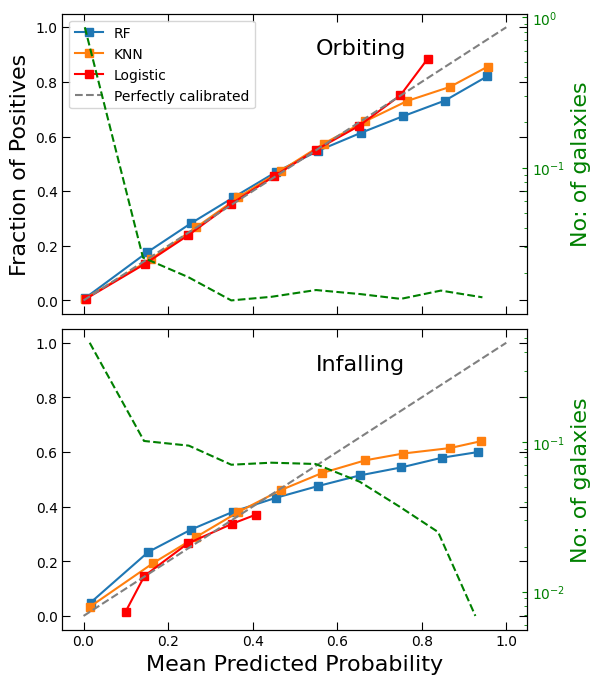

In [213]:
fig = plt.figure(figsize=(6,8))
gs = gridspec.GridSpec(2,1, height_ratios = [1,1], hspace = 0.05)

ax0 = plt.subplot(gs[0])
ax0.plot(cal_curve_orbiting_rf[1], cal_curve_orbiting_rf[0], marker="s", label="RF")
ax0.plot(cal_curve_orbiting_knn[1], cal_curve_orbiting_knn[0], marker="s", label="KNN")
ax0.plot(cal_curve_orbiting_logi[1], cal_curve_orbiting_logi[0], marker="s", label="Logistic", color="r")
ax0.plot(unity_line_xs, unity_line_ys, color="grey", linestyle="--", label="Perfectly calibrated")
ax0.set_ylabel("Fraction of Positives", fontsize=16)
ax0.text(0.55, 0.9, "Orbiting", fontsize=16)
ax0.legend(fontsize=10, loc="best")
ax0.xaxis.set_ticklabels([])
ax0.set_ylabel("Fraction of Positives", fontsize=16)

ax1 = ax0.twinx()
ax1.plot(orbiting_prob_pred, orbiting_num_gals,c='g',ls='--')
ax1.set_yscale('log')
ax1.set_ylabel('No: of galaxies', fontsize=16,c='g')
ax1.tick_params(direction='in',color='g',which='both',labelcolor='g')

ax2 = plt.subplot(gs[1])
ax2.plot(cal_curve_infalling_rf[1], cal_curve_infalling_rf[0], marker="s", label="RF")
ax2.plot(cal_curve_infalling_knn[1], cal_curve_infalling_knn[0], marker="s", label="KNN")
ax2.plot(cal_curve_infalling_logi[1], cal_curve_infalling_logi[0], marker="s", label="Logistic", color="r")
ax2.plot(unity_line_xs, unity_line_ys, color="grey", linestyle="--", label="Perfectly calibrated")
ax0.set_ylabel("Fraction of Positives", fontsize=16)
ax2.set_xlabel("Mean Predicted Probability", fontsize=16)
ax2.text(0.55, 0.9, "Infalling", fontsize=16)

ax3 = ax2.twinx()
ax3.plot(infalling_prob_pred, infalling_num_gals,c='g',ls='--')
ax3.set_yscale('log')
ax3.set_ylabel('No: of galaxies', fontsize=16,c='g')
ax3.tick_params(direction='in',color='g',which='both',labelcolor='g')

ax0.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)
ax2.tick_params(axis='both', direction='in', top='on',which='both',right='on',length=6)